In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

PROCESSING IMAGES

In [22]:
labels = ("glioma", "meningioma", "notumor", "pituitary")
img_dim = (512, 512)

In [23]:
import numpy as np
import os
import cv2

def load_images_dataset(label, num_images, kernal_size, img_dim):
    root = os.path.join(os.getcwd(), 'data') # get system path to data folder
    path = os.path.join(root, label) # get path to label folder
    file_paths = os.listdir(path) # list all files

    random_select = np.random.choice(file_paths, num_images, replace=False) # get N random selection of files
    images = []
    for f in random_select:                                                 # Preprocess images
        img_path = os.path.join(path, f)                                    # Get full file path
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)                    # Read image as grayscale
        img = cv2.resize(img, img_dim, interpolation=cv2.INTER_LINEAR)      # Resize image to correct dimensions
        ksize = (kernal_size, kernal_size)
        blur = cv2.blur(img, ksize)                                         # Blur image with square kernel size given
        normalized_img = cv2.normalize(blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)    # normalize image
        images.append(normalized_img)

    return images

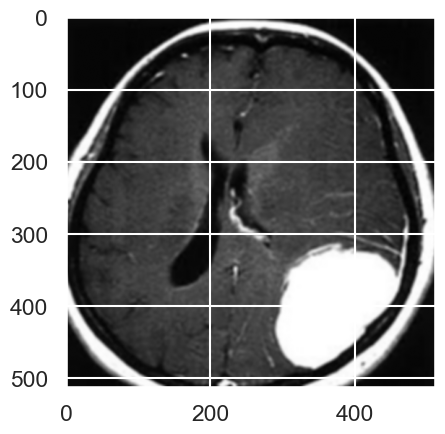

In [24]:
images = load_images_dataset('glioma', 200, 5, img_dim)
plt.imshow(images[1], cmap='gray')

In [25]:
def convert_images_to_np_array(img_list):
    size = len(img_list)
    num_col = img_list[0].shape[0] * img_list[0].shape[1]   # get number of cols by multiplying dims of first image, all same dim

    for i in range(size):
        img_list[i] =  np.ndarray.flatten(img_list[i]).reshape(num_col, 1)      # flatten image

    img_stack = np.dstack(img_list)                                             # Remove extra axis
    img_stack = np.rollaxis(img_stack, axis = 2, start = 0)
    img_stack = img_stack.reshape(size, num_col)

    return img_stack


In [26]:
from sklearn.utils import shuffle
def create_dataframe(num_images, kernal_size, img_dim):

    df_list = []

    for l in labels:    # for each label
        temp_list = load_images_dataset(l, num_images, kernal_size, img_dim)    # load images
        temp_array = convert_images_to_np_array(temp_list)                      # convert images to np arraies
        temp_df = pd.DataFrame(temp_array)                                      # convert each array to a df
        temp_df['label'] = l                                                    # add corresponding label to group of images
        df_list.append(temp_df)

    act = pd.concat(df_list, ignore_index=True)         # combine dataframes into one
    final = shuffle(act).reset_index()                  # shuffle images
    final = final.drop(columns=['index'], axis=1)       # drop unneeded index col

    return final

In [27]:
df = create_dataframe(num_images=200, kernal_size=5, img_dim=img_dim)
print(df.shape)
df.head()
df.tail()

(800, 262145)


,0,1,2,3,4,5,6,7,8,9,...,262135,262136,262137,262138,262139,262140,262141,262142,262143,label
795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,meningioma
796,7,7,6,6,5,5,5,5,5,5,...,5,6,7,7,7,17,68,77,76,notumor
797,0,0,0,0,0,0,0,0,0,0,...,11,9,6,4,3,3,3,3,3,pituitary
798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,notumor
799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,glioma


In [28]:
def split_x_and_y(df):

    x = df.iloc[:, :-1] # get image data from data frame
    y = df.iloc[:, -1]  # get label data from data frame

    return (x, y)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

def multiclass_logistic_regression(solver, test_size, random_state, df):

    data = split_x_and_y(df)    # split the image data from the labels
    x = data[0]
    y = data[1]

    x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=test_size, random_state=random_state)
    mlr = LogisticRegression(solver=solver).fit(x_train, y_train)

    y_pred = mlr.predict(x_test)

    accuracy_score = metrics.accuracy_score(y_test, y_pred)

    return accuracy_score

In [30]:
accuracy_score = multiclass_logistic_regression(solver='newton-cg', test_size=0.2, random_state=42, df=df)
print(f"Multiclass Logistic Regression model accuracy: {accuracy_score * 100:.2f}%")

Multiclass Logistic Regression model accuracy: 53.75%


SUPERVISED LEARNING MODEL

UNSUPERVISED LEARNING MODEL

In [8]:
def kmeans(X, k, max_iter=10, rand_seed=0):
    np.random.seed(rand_seed)
    Mu = X[np.random.choice(X.shape[0],k),:]    
    for i in range(max_iter):
        D = -2*X@Mu.T + (X**2).sum(axis=1)[:,None] + (Mu**2).sum(axis=1)   
        y = np.argmin(D,axis=1)
        Mu = np.array([np.mean(X[y==i],axis=0) for i in range(k)])         
    loss = np.linalg.norm(X - Mu[np.argmin(D,axis=1),:])**2/X.shape[0]   
    return Mu, y, loss

https://www.geeksforgeeks.org/machine-learning/multi-label-image-classification-prediction-of-image-labels/